### Baseline Zero-Shot Forecasting Qwen 2.5 for Time-Series Forecasting 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import transformers
import os
import random
import h5py
import pandas as pd
import time
import importlib
from pprint import pprint
import torch 
from tqdm import tqdm
from src.qwen import load_qwen
import re
import gc
import yaml

device = 'cuda' if torch.cuda.is_available() else 'cpu' 

/home/am3353/am3353/m2-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import src
import src.data_prepare_ntbk
import src.forecast 
import src.preprocess
import src.lora 
import src.data_create

importlib.reload(src)
importlib.reload(src.forecast)
importlib.reload(src.preprocess)
importlib.reload(src.lora)
importlib.reload(src.data_create)
importlib.reload(src.data_prepare_ntbk)

from src.forecast import *
from src.lora import LoRALinear
from src.preprocess import *
from src.data_create import *
from src.data_prepare_ntbk import *  

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
print('Device-activated: ', device)
file_path = "data/lotka_volterra_data.h5"  # Change this to the correct path  Out [9]:  Device-activated:  cpu

Device-activated:  cpu


In [4]:
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              76
On-line CPU(s) list: 0-75
Thread(s) per core:  1
Core(s) per socket:  38
Socket(s):           2
NUMA node(s):        2
Vendor ID:           GenuineIntel
CPU family:          6
Model:               106
Model name:          Intel(R) Xeon(R) Platinum 8368Q CPU @ 2.60GHz
Stepping:            6
CPU MHz:             800.000
CPU max MHz:         3700.0000
CPU min MHz:         800.0000
BogoMIPS:            5200.00
L1d cache:           48K
L1i cache:           32K
L2 cache:            1280K
L3 cache:            58368K
NUMA node0 CPU(s):   0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50,52,54,56,58,60,62,64,66,68,70,72,74
NUMA node1 CPU(s):   1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49,51,53,55,57,59,61,63,65,67,69,71,73,75
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush d

In [5]:
random_state = 28
np.random.seed(random_state)

In [6]:
ft = time.time()
model_lora, tokenizer = load_qwen()
lt = time.time()

print('time-taken: ', (lt - ft)/60, 'mins') 

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


time-taken:  0.02162318229675293 mins


In [7]:
def load_config(config_path):
    with open(config_path, "r") as file:
        config = yaml.safe_load(file)
    return config

manual_config = load_config("src/config.yaml")  
train_split = manual_config['train_split']
time_step_split = manual_config['time_step_split']
batch_size = manual_config['batch_size']
learning_rate = manual_config['learning_rate'] # 1e-5
lora_rank = manual_config['lora_rank']
max_ctx_length = manual_config['seq_length']
forecast_length = manual_config['forecast_length']
max_tokens = manual_config['max_tokens']  

train_split = 0.2
inf_max_tokens = 128
one_time_inf_max_tokens = 128 #1024

In [8]:
data_prey, data_prey_true, data_pred, data_pred_true, time_data_past, time_data_true = load_data(file_path, time_step_split, is_plot = True)
print(data_prey.shape, data_prey_true.shape, data_pred.shape, data_pred_true.shape, time_data_past.shape, time_data_true.shape)

Keys in HDF5 file: ['time', 'trajectories']
(1000, 80) (1000, 21) (1000, 80) (1000, 21) (80,) (21,)


In [9]:
check_rn = random.randint(0, len(data_prey))
print('check_rn: ', check_rn)

check_rn:  517


#### Evolution

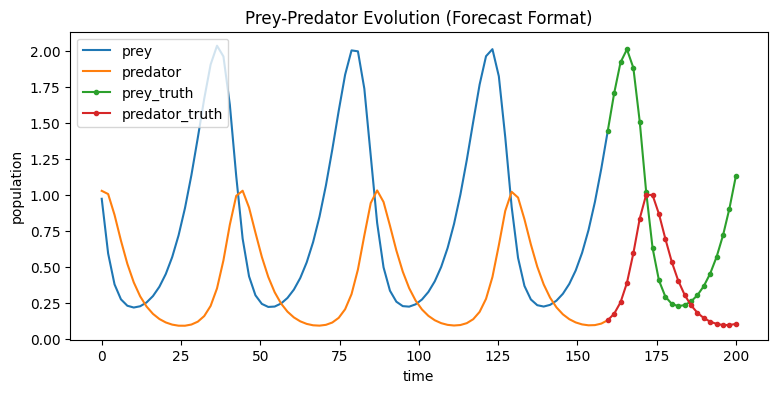

In [10]:
fig = plt.figure(figsize=(9, 4))

plt.plot(time_data_past, data_prey[check_rn], label = 'prey')
plt.plot(time_data_past, data_pred[check_rn], label = 'predator')

plt.plot(time_data_true, data_prey_true[check_rn], label = 'prey_truth', marker = '.')
plt.plot(time_data_true, data_pred_true[check_rn], label = 'predator_truth', marker = '.')

plt.xlabel('time')
plt.ylabel('population')

plt.legend()
plt.title(f'Prey-Predator Evolution (Forecast Format)')
plt.show()  

In [11]:
_, _, prey_os_ins, pred_os_ins, test_encoded_ins = prepare_data(data_prey, data_pred, tokenizer, max_ctx_length, train_split, prep_overlap=True, forecast_length=forecast_length, is_forecast=True)
print(test_encoded_ins.shape)

print()
_, _, prey_os, pred_os, test_encoded = prepare_data(data_prey, data_pred, tokenizer, max_ctx_length, train_split, prep_overlap=False, forecast_length=5, is_forecast=True)
print(test_encoded.shape)

(100,)

---- Example-Prompt ----

PROMPT: 
<|im_start|>user
Predict the next prey and predator populations based on the historical data.
Historical data: 0.236, 0.922  0.231, 0.697  0.234, 0.541  0.242, 0.435  0.257, 0.365  0.276, 0.317<|im_end|>
<|im_start|>assistant


TARGET: 
0.302, 0.286  0.334, 0.265  0.372, 0.251  0.416, 0.242  0.467, 0.237<|im_end|>
---- Example-Prompt ----

PROMPT: 
<|im_start|>user
Predict the next prey and predator populations based on the historical data.
Historical data: 1.022, 0.567  0.99, 0.716  0.898, 0.855  0.763, 0.959  0.615, 1.008  0.48, 0.998<|im_end|>
<|im_start|>assistant


TARGET: 
0.373, 0.936  0.297, 0.84  0.253, 0.726  0.236, 0.607  0.244, 0.496<|im_end|>
(100,)


#### Qwen 2.5 (Untrained) - Zero Shot Forecasting

Qwen's Interfacing

```
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "Qwen/Qwen2.5-0.5B-Instruct"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(model_name)

prompt = "Give me a short introduction to large language model."
messages = [
    {"role": "system", "content": "You are Qwen, created by Alibaba Cloud. You are a helpful assistant."},
    {"role": "user", "content": prompt}
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)
model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

generated_ids = model.generate(
    **model_inputs,
    max_new_tokens=512
)
generated_ids = [
    output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
]

response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

```

In [12]:
print(model_lora.config)

print()

print(model_lora)

Qwen2Config {
  "_attn_implementation_autoset": true,
  "_name_or_path": "Qwen/Qwen2.5-0.5B-Instruct",
  "architectures": [
    "Qwen2ForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 151643,
  "eos_token_id": 151645,
  "hidden_act": "silu",
  "hidden_size": 896,
  "initializer_range": 0.02,
  "intermediate_size": 4864,
  "max_position_embeddings": 32768,
  "max_window_layers": 21,
  "model_type": "qwen2",
  "num_attention_heads": 14,
  "num_hidden_layers": 24,
  "num_key_value_heads": 2,
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "rope_theta": 1000000.0,
  "sliding_window": 32768,
  "tie_word_embeddings": true,
  "torch_dtype": "float32",
  "transformers_version": "4.49.0",
  "use_cache": true,
  "use_sliding_window": false,
  "vocab_size": 151936
}


Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_

### See Tokenization (2 Sequences/Systems)

In [13]:
for i in range(2):
    encoded_seq = str(test_encoded_ins[i])
    print(f'Encoded-Sequence-{i}: ', encoded_seq[:100], '...')
    token_seq = tokenizer(encoded_seq, return_tensors="pt").input_ids[0]
    print(f'Tokenized-Sequence-{i}: ', token_seq)
    print()

Encoded-Sequence-0:  0.517, 0.905; 0.404, 0.895; 0.329, 0.82; 0.285, 0.717; 0.262, 0.613; 0.251, 0.523; 0.248, 0.45; 0.25 ...
Tokenized-Sequence-0:  tensor([15, 13, 20,  ..., 16, 19, 26])

Encoded-Sequence-1:  0.38, 1.014; 0.287, 0.84; 0.248, 0.656; 0.238, 0.508; 0.246, 0.402; 0.268, 0.331; 0.305, 0.284; 0.35 ...
Tokenized-Sequence-1:  tensor([15, 13, 18,  ..., 15, 18, 26])



In [14]:
import src.forecast
importlib.reload(src.forecast)
from src.forecast import *

There are two ways of doing forecasting --> 
1. One-lining: you set a relatively high inference_max_token then generate a large string on a single pass, then cut it off at your desired forecast_length ~ O(1) Constant time-complexity
2. Iteratively: Iteratively generate one token after the other with low inf_max_token limit    

#### Untrained Qwen Forecasting

##### Instruction-Based-Preprocessing

In [ ]:
one_time_inf_max_tokens = 256

In [16]:
rn = random.randint(0, len(test_encoded_ins) - 1)
test_prompt_ins = test_encoded_ins[rn]

print('Test-Prompt: ')
print(test_prompt_ins)

ft = time.time()
print('Inference-Token / Inference Sequence Length (can be equal to Context Length): ', one_time_inf_max_tokens)
test_prompt_ins = create_forecast_prompt_joint(test_prompt_ins, forecast_length=21, is_show = True)
prey_pred_response = generate_forecast(model_lora, test_prompt_ins, tokenizer, max_new_tokens=one_time_inf_max_tokens, temperature=0.1)
print('prey_pred_response', len(prey_pred_response))
lt = time.time()

print('time-taken: ', (lt - ft) / 60)

print(repr(prey_pred_response))

Test-Prompt: 
0.233, 0.671; 0.269, 0.523; 0.329, 0.402; 0.413, 0.313; 0.515, 0.256; 0.63, 0.233; 0.747, 0.245; 0.855, 0.29; 0.943, 0.367; 0.997, 0.472; 1.011, 0.595; 0.982, 0.724; 0.918, 0.844; 0.827, 0.94; 0.727, 0.997; 0.63, 1.011; 0.548, 0.985; 0.485, 0.926; 0.446, 0.847; 0.429, 0.759; 0.433, 0.672; 0.454, 0.594; 0.491, 0.531; 0.54, 0.484; 0.597, 0.457; 0.657, 0.45; 0.714, 0.462; 0.763, 0.493; 0.798, 0.538; 0.816, 0.595; 0.816, 0.657; 0.798, 0.718; 0.766, 0.77; 0.723, 0.809; 0.677, 0.831; 0.632, 0.834; 0.593, 0.82; 0.563, 0.791; 0.544, 0.753; 0.536, 0.71; 0.539, 0.667; 0.551, 0.628; 0.572, 0.595; 0.599, 0.572; 0.629, 0.56; 0.66, 0.558; 0.688, 0.567; 0.71, 0.586; 0.726, 0.611; 0.732, 0.641; 0.73, 0.672; 0.72, 0.701; 0.703, 0.726; 0.681, 0.743; 0.658, 0.752; 0.636, 0.752; 0.617, 0.744; 0.603, 0.729; 0.594, 0.71; 0.59, 0.689; 0.592, 0.667; 0.599, 0.648; 0.61, 0.632; 0.624, 0.62; 0.639, 0.614; 0.654, 0.614; 0.668, 0.619; 0.679, 0.628; 0.687, 0.641; 0.69, 0.656; 0.689, 0.671; 0.685, 0.68

In [18]:
prey_decoded_response, pred_decoded_response = extract_forecasts(prey_pred_response)

print(len(prey_decoded_response), len(pred_decoded_response))
print(prey_decoded_response)

prey_decoded_response = ts_decoding(prey_decoded_response, model_type="llama", precision=3, offsets=prey_os['offset'][check_rn], scale_factors=prey_os['scale'][check_rn])[:forecast_length]
pred_decoded_response = ts_decoding(pred_decoded_response, model_type="llama", precision=3, offsets=pred_os['offset'][check_rn], scale_factors=pred_os['scale'][check_rn])[:forecast_length]

254 251
0.63, 0.747, 0.855, 0.943, 0.997, 1.011, 0.982, 0.918, 0.827, 0.727, 0.63, 0.548, 0.485, 0.446, 0.429, 0.433, 0.454, 0.491, 0.54, 0.597, 0.657, 0.714, 0.763, 0.798, 0.816, 0.816, 0.798, 0.766, 0.723, 0.677, 0.632, 0.593, 0.563, 0.544, 0.536, 0.539, 0.551


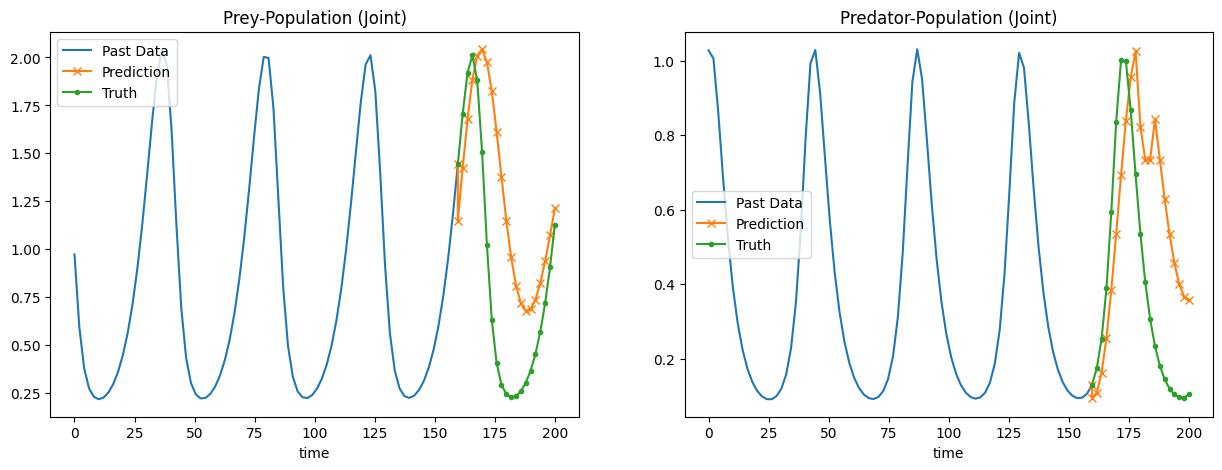

In [27]:
fig, axs = plt.subplots(1, 2, figsize = (15, 5))

prey_pred = [data_prey[check_rn].tolist()[-1]] + prey_decoded_response.tolist()
prey_time = [time_data_past[-1]] + time_data_true[:len(prey_decoded_response)].tolist()

axs[0].plot(time_data_past, data_prey[check_rn].tolist(), label = 'Past Data')
axs[0].plot(prey_time, prey_pred, label = 'Prediction', marker = 'x')
axs[0].plot(time_data_true, data_prey_true[check_rn].tolist(), label = 'Truth', marker = '.')

axs[0].set_title('Prey-Population (Joint)')
axs[0].set_xlabel('time')
axs[0].legend()

pred_pred = [data_pred[check_rn].tolist()[-1]] + pred_decoded_response.tolist()
pred_time = [time_data_past[-1]] + time_data_true[:len(prey_decoded_response)].tolist()

axs[1].plot(time_data_past, data_pred[check_rn].tolist(), label = 'Past Data')
axs[1].plot(pred_time, pred_pred, label = 'Prediction', marker = 'x')
axs[1].plot(time_data_true, data_pred_true[check_rn].tolist(), label = 'Truth', marker = '.')

axs[1].set_title('Predator-Population (Joint)')
axs[1].set_xlabel('time')
axs[1].legend()

plt.show()

##### Basic Input

In [28]:
rn = random.randint(0, len(test_encoded)) ### Test Encode contain train-samples as well
test_prompt = test_encoded[rn]

print('Test-Prompt: ')
print(test_prompt)

ft = time.time()
print('Inference-Token / Sequence Length (can be equal to Context Length): ', one_time_inf_max_tokens)
prey_pred_response = generate_forecast(model_lora, test_prompt, tokenizer, max_new_tokens=one_time_inf_max_tokens, temperature=0.1)
print('prey_pred_response', len(prey_pred_response))
lt = time.time()

print('time-taken: ', (lt - ft) / 60)

print(repr(prey_pred_response))

Test-Prompt: 
0.351, 0.935; 0.292, 0.823; 0.258, 0.703; 0.239, 0.593; 0.232, 0.503; 0.231, 0.431; 0.236, 0.376; 0.246, 0.334; 0.26, 0.302; 0.278, 0.279; 0.302, 0.262; 0.33, 0.25; 0.365, 0.241; 0.406, 0.236; 0.453, 0.233; 0.507, 0.232; 0.568, 0.234; 0.636, 0.239; 0.708, 0.247; 0.783, 0.261; 0.857, 0.282; 0.925, 0.315; 0.977, 0.365; 1.002, 0.439; 0.987, 0.543; 0.921, 0.678; 0.804, 0.827; 0.654, 0.951; 0.507, 1.006; 0.392, 0.972; 0.316, 0.876; 0.272, 0.757; 0.247, 0.641; 0.235, 0.542; 0.231, 0.462; 0.234, 0.4; 0.241, 0.352; 0.253, 0.316; 0.27, 0.289; 0.291, 0.27; 0.317, 0.255; 0.349, 0.245; 0.387, 0.238; 0.431, 0.234; 0.482, 0.232; 0.54, 0.233; 0.605, 0.236; 0.675, 0.243; 0.75, 0.254; 0.825, 0.272; 0.896, 0.299; 0.956, 0.341; 0.995, 0.403; 1.0, 0.493; 0.957, 0.615; 0.862, 0.762; 0.723, 0.904; 0.569, 0.994; 0.437, 0.998; 0.345, 0.925; 0.288, 0.811; 0.256, 0.691; 0.239, 0.584; 0.232, 0.495; 0.232, 0.425; 0.237, 0.371; 0.247, 0.331; 0.262, 0.3; 0.281, 0.278; 0.305, 0.261; 0.334, 0.249; 0.369

In [29]:
prey_decoded_response, pred_decoded_response = extract_forecasts(prey_pred_response)

print(len(prey_decoded_response), len(pred_decoded_response))
print(prey_decoded_response)

prey_decoded_response = ts_decoding(prey_decoded_response, model_type="llama", precision=3, offsets=prey_os['offset'][check_rn], scale_factors=prey_os['scale'][check_rn])[:forecast_length]
pred_decoded_response = ts_decoding(pred_decoded_response, model_type="llama", precision=3, offsets=pred_os['offset'][check_rn], scale_factors=pred_os['scale'][check_rn])[:forecast_length]

255 254
0.928, 0.988, 1.002, 0.987, 0.921, 0.804, 0.654, 0.507, 0.392, 0.316, 0.272, 0.247, 0.235, 0.231, 0.234, 0.241, 0.253, 0.27, 0.239, 0.232, 0.232, 0.237, 0.247, 0.262, 0.281, 0.305, 0.334, 0.369, 0.41, 0.458, 0.513, 0.575, 0.643, 0.716, 0.792, 0.865, 0.928


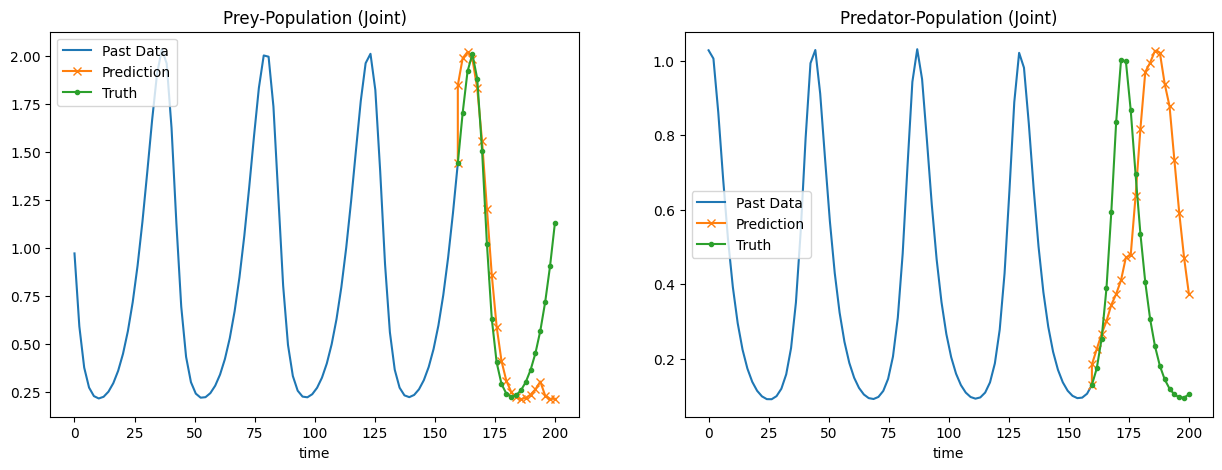

In [30]:
fig, axs = plt.subplots(1, 2, figsize = (15, 5))

prey_pred = [data_prey[check_rn].tolist()[-1]] + prey_decoded_response.tolist()
prey_time = [time_data_past[-1]] + time_data_true[:len(prey_decoded_response)].tolist()

axs[0].plot(time_data_past, data_prey[check_rn].tolist(), label = 'Past Data')
axs[0].plot(prey_time, prey_pred, label = 'Prediction', marker = 'x')
axs[0].plot(time_data_true, data_prey_true[check_rn].tolist(), label = 'Truth', marker = '.')

axs[0].set_title('Prey-Population (Joint)')
axs[0].set_xlabel('time')
axs[0].legend()

pred_pred = [data_pred[check_rn].tolist()[-1]] + pred_decoded_response.tolist()
pred_time = [time_data_past[-1]] + time_data_true[:len(prey_decoded_response)].tolist()

axs[1].plot(time_data_past, data_pred[check_rn].tolist(), label = 'Past Data')
axs[1].plot(pred_time, pred_pred, label = 'Prediction', marker = 'x')
axs[1].plot(time_data_true, data_pred_true[check_rn].tolist(), label = 'Truth', marker = '.')

axs[1].set_title('Predator-Population (Joint)')
axs[1].set_xlabel('time')
axs[1].legend()

plt.show()

In [21]:
from scipy import stats
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
def compute_forecasting_metrics(true_data, predicted_data):
    
    true_prey, true_pred = true_data
    predicted_prey, predicted_pred = predicted_data[:, 0, :], predicted_data[:, 1, :]
    
    metrics = {'Prey' : {}, 'Predator' : {}}
    data_true = {'Prey': true_prey, 'Predator': true_pred}
    data_predicted = {'Prey': predicted_prey, 'Predator': predicted_pred}
    
    for m in metrics:
        
        # Basic Regression Metrics
        predicted = data_predicted[m]
        true = data_true[m][:, :predicted.shape[-1]]
        
        print(predicted.shape, true.shape)
        
        metrics[m]['MAE'] = mean_absolute_error(true, predicted)
        metrics[m]['MSE'] = mean_squared_error(true, predicted)
        metrics[m]['RMSE'] = np.sqrt(metrics[m]['MSE'])
        metrics[m]['MAPE'] = np.mean(np.abs((true - predicted) / true)) * 100
        
        # Normalized RMSE
        metrics[m]['NRMSE'] = metrics[m]['RMSE'] / (np.max(true) - np.min(true))
        
        # R² Score
        metrics[m]['R2'] = r2_score(true, predicted)
    
    return metrics

def visualize_forecast_comparison(true_data, predicted_data, rn):
    """
    Create visualization comparing true and predicted trajectories
    
    Args:
    true_data (np.ndarray): Ground truth time series data
    predicted_data (np.ndarray): Model predicted time series data
    save_path (str): Path to save the visualization
    """
    plt.figure(figsize=(12, 6))
    
    # plt.plot(time_data_past, true_data[check_rn].tolist(), label = 'Past Data')
    plt.plot(time_data_true[:len(predicted_data[0])], predicted_data[0], label = 'Prediction (Prey)', marker = 'x')
    plt.plot(time_data_true[:len(predicted_data[0])], true_data[0].tolist()[:len(predicted_data[0])], label = 'Truth (Prey)', marker = '.')

    # plt.plot(time_data_past, data_pred[check_rn].tolist(), label = 'Past Data')
    plt.plot(time_data_true[:len(predicted_data[-1])], predicted_data[-1], label = 'Prediction (Predator)', marker = 'x')
    plt.plot(time_data_true[:len(predicted_data[-1])], true_data[-1].tolist()[:len(predicted_data[-1])], label = 'Truth (Predator)', marker = '.')

    plt.xlabel('time')
    plt.title('Prey-Predator-Population (Forecast) (Pred-Cut)')
    plt.legend()
    plt.grid()
    plt.show()

def evaluate_lora_model(model, test_prompts, true, tokenizer, inf_max_token, is_instruction = False):
    
    pred_batch = []
    
    for i, test_prompt in enumerate(test_prompts):
        if is_instruction:
            test_prompt = create_forecast_prompt_joint(test_prompt, forecast_length=21, is_show = True)
        
        prey_pred_response = generate_forecast(model, test_prompt, tokenizer, max_new_tokens=inf_max_token, temperature=0.1)
        prey_decoded_response, pred_decoded_response = extract_forecasts(prey_pred_response)
        prey_decoded_response = ts_decoding(prey_decoded_response, model_type="llama", precision=3, offsets=prey_os['offset'][i], scale_factors=prey_os['scale'][i])[:forecast_length]
        pred_decoded_response = ts_decoding(pred_decoded_response, model_type="llama", precision=3, offsets=pred_os['offset'][check_rn], scale_factors=pred_os['scale'][check_rn])[:forecast_length]
        
        min_len = min(len(prey_decoded_response), len(pred_decoded_response))
        ### This can be inhomogenous because the min_len can be different for different generations
        # pred_batch.append([prey_decoded_response[:min_len], pred_decoded_response[:min_len]])
        pred_batch.append([prey_decoded_response, pred_decoded_response])
    
    ## for homogeneity
    min_len = min([min(len(data[0]), len(data[-1])) for data in pred_batch])      
    pred_batch = [[data[0][:min_len], data[-1][:min_len]] for data in pred_batch]
    pred_batch = np.array(pred_batch)
    metrics = compute_forecasting_metrics(true, pred_batch)
    
    rn = random.randint(0, len(pred_batch[0]) - 1)
    visualize_forecast_comparison([true[0][rn], true[-1][rn]], [pred_batch[0][rn], pred_batch[-1][rn]], rn)
    
    return metrics


In [42]:
rn_idx = np.random.permutation(len(test_encoded))
test_prompts = test_encoded[rn_idx]
val_true_prey, val_true_pred = data_prey_true[int(train_split * len(data_prey_true)):], data_pred_true[int(train_split * len(data_pred_true)):]
val_true_prey, val_true_pred = val_true_prey[rn_idx], val_true_pred[rn_idx]

idx = 5
test_prompts, val_true_prey, val_true_pred = test_prompts[:idx], val_true_prey[:idx], val_true_pred[:idx]
print(test_prompts.shape, val_true_prey.shape, val_true_pred.shape)

(5,) (5, 21) (5, 21)


(5, 9) (5, 9)
(5, 9) (5, 9)


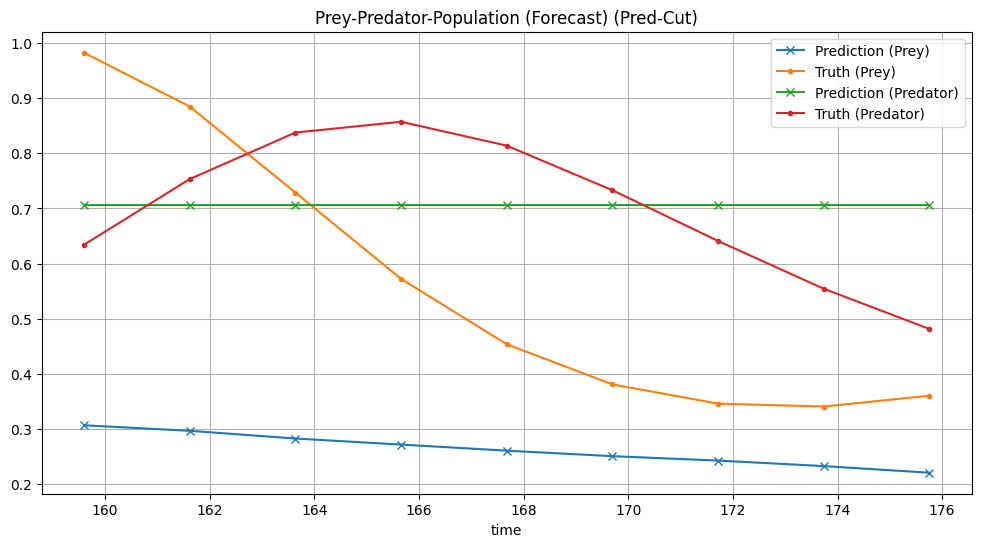

{'Predator': {'MAE': 0.32235548585255946,
              'MAPE': np.float64(42.62582279521068),
              'MSE': 0.13889501191912565,
              'NRMSE': np.float64(0.3310231343852334),
              'R2': -0.0024976897807659957,
              'RMSE': np.float64(0.3726862110665293)},
 'Prey': {'MAE': 1.1790700555271574,
          'MAPE': np.float64(63.10198000563384),
          'MSE': 3.2715625902419188,
          'NRMSE': np.float64(0.3439987358049727),
          'R2': 0.007190325506987481,
          'RMSE': np.float64(1.8087461375886664)}}


In [43]:
metrics = evaluate_lora_model(model_lora, test_prompts, [val_true_prey, val_true_pred], tokenizer, inf_max_token=inf_max_tokens)
pprint(metrics)